<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


LOAD COMPAS data

In [31]:
compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')

In [30]:
target = "Two_yr_Recidivism"
X = ofercompas.drop([target],axis=1)
Y = ofercompas[target]
age = originalcompas['age']

TRAIN  Model

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, stratify = Y)

model = RandomForestClassifier()
model.fit(X_train, Y_train)

#predictions
Yhat = model.predict(X_test)
len(Yhat)


1852

COLLECT the errors

In [6]:
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.6550
[[731 278]
 [361 482]]


In [7]:
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])
predictions['errors'] = predictions['errors'].replace(2.0, 1.0)


data_pred = X_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = data_pred['errors']
ofercompas_out = data_pred.drop(['predicted_class', 'true_class', 'errors'], axis=1)

display(data_pred.columns)
print(len(data_pred))
data_pred[data_pred['errors']==1]

Index(['Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive',
       'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female', 'Misdemeanor', 'predicted_class',
       'true_class', 'errors'],
      dtype='object')

1852


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors
2401,1,1,0,1,1,0,0,0,0,0,0,1,0,1
3111,0,1,0,0,0,0,0,0,0,0,0,0,1,1
452,1,0,0,0,0,0,0,0,1,0,0,1,0,1
2580,1,0,0,0,0,0,0,0,1,0,0,1,0,1
348,2,0,1,0,0,0,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,4,1,0,0,1,0,0,0,0,1,0,0,1,1
4361,2,0,0,0,0,0,0,0,0,0,1,0,1,1
2226,4,1,0,0,1,0,0,0,0,0,1,0,1,1
2514,1,0,0,1,1,0,0,0,0,0,0,1,0,1


Selecting 4 labels (FP, FN, TP, TN)

In [13]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    # Calculate confusion matrix for each instance
    cm = confusion_matrix([true_class], [predicted_class])

    # Extract TP, FP, FN, TN
    TP = cm[0, 0] if len(set([true_class, predicted_class])) == 2 and true_class == 1 else 0
    FP = cm[0, 1] if len(set([true_class, predicted_class])) == 2 and true_class == 0 else 0
    FN = cm[1, 0] if len(set([true_class, predicted_class])) == 2 and true_class == 1 else 0
    TN = cm[1, 1] if len(set([true_class, predicted_class])) == 2 and true_class == 0 else 0

    # Determine the error type

    row['TP'] = TP
    row['FP'] = FP
    row['FN'] = FN
    row['TN'] = TN

    return row


# Apply the function to each row
data_pred = data_pred.apply(get_error_type, axis=1)

# Display the result
print(data_pred)
display(data_pred.columns)




      Number_of_Priors  score_factor  Age_Above_FourtyFive  \
1438                 4             1                     0   
2777                10             1                     0   
2212                 0             0                     0   
5763                 0             0                     1   
3086                 1             1                     0   
...                ...           ...                   ...   
5932                 3             1                     0   
469                  3             0                     0   
835                  2             1                     0   
2768                 1             0                     0   
3902                 0             0                     0   

      Age_Below_TwentyFive  African_American  Asian  Hispanic  \
1438                     0                 0      0         0   
2777                     0                 0      0         0   
2212                     0                 1      0         

Index(['Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive',
       'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female', 'Misdemeanor', 'predicted_class',
       'true_class', 'errors', 'TP', 'FP', 'FN', 'TN'],
      dtype='object')

Scatterplot 4 labels (TP, FP, FN, TN) --> discrete variable problem. Scatterplotted on cox_violent_parsed_filt dataset

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')

Text(0.5, 0, 'age')

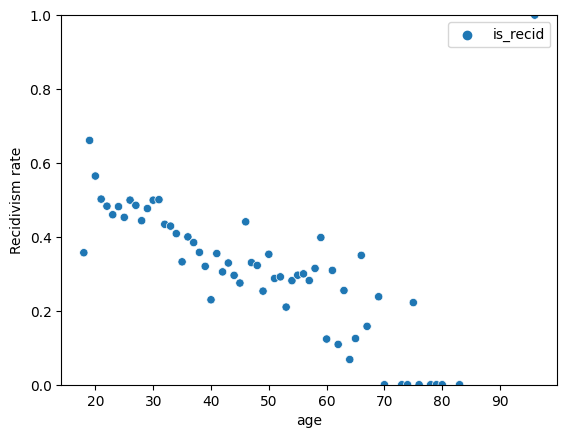

In [38]:
display(cox_violent_filt.columns)
d = cox_violent_filt.groupby('age').agg({'is_recid':'mean'})

sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate')
plt.xlabel('age')


PCA 4 labels (FP, FN, TP, TN)